## Binomial Tree Model

We can price options in discrete time through lattice models. The first model we consider is the Cox-Ross-Rubinstein Model which is risk neutral under Martingale measure $\mathbb{Q}$. We say a process $S$ is a Martingale with respect to measure $\mathbb{Q}$ and filtration $\{\mathcal{F}_t\}_{t \geq 0}$, if $\mathbb{E}^{\mathbb{Q}}[X_t \mid \mathcal{F}_s] = X_s \quad \forall \, s\leq t$, this means the process is path unbiased.

According to this model the stock at time $t$ can move to up by a factor of $u$ with probability $p$ and down by a factor of $d$ with probability $(1-p)$ at the next time step $t+1$. Using the principle of no arbitrage, the stock earns a risk free interest ($r$) and parameters $d < 1 < u$. The risk neutral probability $p$ is then given by mean matching.

\begin{equation}
\begin{split}

&\mathbb{E}[S_{t+\Delta t}]=S_0e^{r\Delta t} \\
&S_0e^{r\Delta t}=S_0u\cdot p+S_0d\cdot(1-p) \\
&\implies p = \frac{e^{r\Delta t}-d}{u-d}

\end{split}
\end{equation}

Similary the call option $c_0 = e^{-rT}(c_u\cdot p+c_d\cdot(1-p))$. We can evaluate $u$ and $d$ by matching the variance.

\begin{equation}
\begin{split}

&\mathbb{V}(S_{t+\Delta t})=\mathbb{E}[S_{t+\Delta t}^2] - \mathbb{E}[S_{t+\Delta t}]^2  \\
&\sigma^2 \Delta t =p \cdot u^2 + d^2(1-p) + (p \cdot u^2 + d^2(1-p))^2 \\
&\sigma^2 \Delta t =(p -p^2)(u-d)^2 \\
&\sigma^2 \Delta t = e^{r\Delta t} (u+d) - u \cdot d - e^{2r\Delta t} \\
&\sigma^2 \Delta t = e^{r\Delta t} (u+1/u) - u \cdot 1/u - e^{2r\Delta t} \quad  \text{[$u\cdot d=1$ ]} \\
&u= e^{\sigma \sqrt{\Delta t}}, d = e^{-\sigma \sqrt{\Delta t}}

\end{split}
\end{equation}

The above definitions rely on a sufficiently small $\Delta t$ for $p$ to be a valid probability.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from enum import Enum

In [ ]:
class OptionType(Enum):
    call, put = range(0,2)

European Binomial Tree

In [ ]:
@dataclass
class Option:
    s_ini: float
    strike_price: float
    maturity: float
    risk_free_rate: float
    sigma: float
    steps: int
    option_type: OptionType

In [4]:
class BinomialTree:
    def __init__(self, option: Option):
        self.option = option
        self.dt = option.maturity / option.steps
        self.u = np.exp(option.sigma * np.sqrt(self.dt))
        self.d = np.exp(-option.sigma * np.sqrt(self.dt))
        self.p = (np.exp(option.risk_free_rate * self.dt) - self.d) / (self.u - self.d)
        self.price_matrix = np.zeros([option.steps + 1, option.steps + 1])
        self.underlying_matrix = np.zeros([option.steps + 1, option.steps + 1])
        self.delta_matrix = np.zeros([option.steps, option.steps])

    def payoff(self, stock_vec):
        if self.option.option_type == OptionType.call:
            return np.maximum(stock_vec - self.option.strike_price, 0)
        else:
            return np.maximum(self.option.strike_price - stock_vec, 0)

    def price(self):

        N = self.option.steps
        for i in range(0, N + 1):

            # price on tree edges
            self.underlying_matrix[N, i] = (
                self.option.s_ini * (self.u ** (i)) * (self.d ** (N - i))
            )

            self.price_matrix[N, i] = self.payoff(self.underlying_matrix[N, i])

        for j in range(N - 1, -1, -1):
            for i in range(0, j + 1):
                self.price_matrix[j, i] = np.exp(
                    -self.option.risk_free_rate * self.dt
                ) * (
                    self.p * self.price_matrix[j + 1, i + 1]
                    + (1 - self.p) * self.price_matrix[j + 1, i]
                )
                self.underlying_matrix[j, i] = (
                    self.option.s_ini * (self.u ** (i)) * (self.d ** (j - i))
                )
                self.delta_matrix[j, i] = (
                    self.price_matrix[j + 1, i + 1] - self.price_matrix[j + 1, i]
                ) / (
                    self.underlying_matrix[j + 1, i + 1]
                    - self.underlying_matrix[j + 1, i]
                )

        return {
            "price": self.price_matrix[0, 0],
            "price_evolution" : self.price_matrix,
            "underlying": self.underlying_matrix,
            "delta": self.delta_matrix,
        }

In [5]:
# Option parameters (ATM option)
S_in = 100
K  = 100
T = 3/12
r = 0.05
sigma = 0.2
N = 200

In [6]:
call_option = Option(S_in, K, T,r, sigma, N, OptionType.call)
binomial_tree = BinomialTree(call_option)
call_price = binomial_tree.price()["price"]
print("call price: {:.2f}".format(call_price))

call price: 4.61


In [7]:
put_option = Option(S_in, K, T,r, sigma, N, OptionType.put)
binomial_tree = BinomialTree(put_option)
put_price = binomial_tree.price()["price"]
print("put price: {:.2f}".format(put_price))

put price: 3.37


verify results using Put Call Parity, $C+K e^{-rT}=S+P$

In [8]:
assert np.round(call_price + K*np.exp(-r*T)) == np.round(S_in + put_price)

## Delta Hedging

We define a porfolio $\prod_{t}^{}$, under the principle of no arbitrage the portfolio is worth the same at time $t$ regardless of the path takes to $t+1$. Only the weights of the assets is allowed to change in the portfolio, no cash injection or deposits are allowed once the portfolio has been created, this is referred to as a self financing trading strategy.

\begin{equation}
\begin{split}

\prod_{t,u}^{}=\Delta S_0 u - c_u  \quad  \text{upward movement} \\

\end{split}
\end{equation}


\begin{equation}
\begin{split}

\prod_{t,d}^{}=\Delta  S_0 d - c_d  \quad  \text{downward movement} \\

\end{split}
\end{equation}

Rebalancing under this constraints leads to delta hedging.

\begin{equation}
\begin{split}

&\Delta  S_0 d - c_d=\Delta S_0 u - c_u \\
&\Delta =\frac{c_u-c_d}{S_0 u - S_0 d}

\end{split}
\end{equation}

$\Delta$ is the amount of the underlying that we must own for the portfolio to admit no arbitrage.

In [12]:
call_option = Option(S_in, K, T,r, sigma, N, OptionType.call)
put_option = Option(S_in, K, T,r, sigma, N, OptionType.put)

res_call = BinomialTree(call_option).price()
res_put = BinomialTree(put_option).price()

In [14]:
call_delta = res_call["delta"][0][0]
print("call delta: {:.2f}".format(call_delta))

call delta: 0.57


In [15]:
put_delta = res_put["delta"][0][0]
print("put delta: {:.2f}".format(put_delta))

put delta: -0.43


Verify deltas

In [16]:
assert np.round(call_delta - put_delta) == np.round(1)

Computing vega

In [17]:
sigma_25 = 0.25
call_option_sigma_25 = Option(S_in, K, T,r, sigma_25, N, OptionType.call)
put_option_sigma_25 = Option(S_in, K, T,r, sigma_25, N, OptionType.put)

sigma20_call_price = BinomialTree(call_option).price()["price"]
sigma20_put_price = BinomialTree(put_option).price()["price"]

sigma25_call_price = BinomialTree(call_option_sigma_25).price()["price"]
sigma25_put_price = BinomialTree(put_option_sigma_25).price()["price"]


In [18]:
sigma25_call_price

5.592182913856925

In [19]:
#vega

call_vega = (sigma25_call_price-sigma20_call_price)/0.05
put_vega = (sigma25_put_price-sigma20_put_price)/0.05

print("call vega: {:.2f}".format(call_vega))
print("put vega: {:.2f}".format(put_vega))


call vega: 19.64
put vega: 19.64


American Binomial Tree

In [20]:
class AmericanBinomialTree(BinomialTree):
    def __init__(self, option: Option):
        super().__init__(option)

    def get_max_payoff(self, discounted_payofff, s_t):
        if self.option.option_type == OptionType.call:
            return max(s_t - self.option.strike_price, discounted_payofff)
        else:
            return max(self.option.strike_price - s_t, discounted_payofff)

    def price(self):
        N = self.option.steps
        for i in range(0, N + 1):

            # price on tree edges
            self.underlying_matrix[N, i] = (
                self.option.s_ini * (self.u ** (i)) * (self.d ** (N - i))
            )

            # call
            if self.option.option_type == OptionType.call:
                self.price_matrix[N, i] = max(
                    self.underlying_matrix[N, i] - self.option.strike_price, 0
                )
            # put
            else:
                self.price_matrix[N, i] = max(
                    self.option.strike_price - self.underlying_matrix[N, i], 0
                )

        for j in range(N - 1, -1, -1):
            for i in range(0, j + 1):
                #discounted payoff
                self.price_matrix[j, i] = np.exp(
                    -self.option.risk_free_rate * self.dt
                ) * (
                    self.p * self.price_matrix[j + 1, i + 1]
                    + (1 - self.p) * self.price_matrix[j + 1, i]
                )
                self.underlying_matrix[j, i] = (
                    self.option.s_ini * (self.u ** (i)) * (self.d ** (j - i))
                )

                #compare leaving payoff and payff at exercise
                self.price_matrix[j, i] = self.get_max_payoff(
                    self.price_matrix[j, i], self.underlying_matrix[j, i]
                )

                self.delta_matrix[j, i] = (
                    self.price_matrix[j + 1, i + 1] - self.price_matrix[j + 1, i]
                ) / (
                    self.underlying_matrix[j + 1, i + 1]
                    - self.underlying_matrix[j + 1, i]
                )

        return {
            "price": self.price_matrix[0, 0],
            "price_evolution" : self.price_matrix,
            "underlying": self.underlying_matrix,
            "delta": self.delta_matrix,
        }

Example

In [21]:
american_call = Option(100, 67, 10, 0.04, 0.3, 10, OptionType.put)
american_tree = AmericanBinomialTree(american_call)

print("american call price: {}".format(american_tree.price()["price"]))

american call price: 8.426654929491738


## Trinomial Tree

Trinomial Tree

In [22]:
class TrinomialModel:
    def __init__(self, option: Option):
        self.option = option
        self.s0 = self.option.s_ini
        self.r = self.option.risk_free_rate
        self.sigma = self.option.sigma
        self.T = self.option.maturity
        self.dt = self.option.maturity / self.option.steps

        self.price_matrix = []
        self.underlying_matrix = []

    def compute_probs(self):
        self.pu = (
            (np.exp(self.r * self.dt / 2) - np.exp(-self.sigma * np.sqrt(self.dt / 2)))
            / (
                np.exp(self.sigma * np.sqrt(self.dt / 2))
                - np.exp(-self.sigma * np.sqrt(self.dt / 2))
            )
        ) ** 2
        self.pd = (
            (-np.exp(self.r * self.dt / 2) + np.exp(self.sigma * np.sqrt(self.dt / 2)))
            / (
                np.exp(self.sigma * np.sqrt(self.dt / 2))
                - np.exp(-self.sigma * np.sqrt(self.dt / 2))
            )
        ) ** 2
        self.pm = 1 - self.pu - self.pd

        assert 0 <= self.pu <= 1.0, "p_u should lie in [0, 1] given %s" % self.pu
        assert 0 <= self.pd <= 1.0, "p_d should lie in [0, 1] given %s" % self.pd
        assert 0 <= self.pm <= 1.0, "p_m should lie in [0, 1] given %s" % self.pm

    def check_up_value(self, up):
        if up is None:
            up = np.exp(self.sigma * np.sqrt(2 * self.dt))

        assert up > 0.0, "up should be non negative"

        down = 1 / up

        assert down < up, "up <= 1. / up = down"

        self.up = up
        self.down = down

    def gen_stock_vec(self, nb):
        vec_u = self.up * np.ones(nb)
        np.cumprod(vec_u, out=vec_u)

        vec_d = self.down * np.ones(nb)
        np.cumprod(vec_d, out=vec_d)

        res = np.concatenate((vec_d[::-1], [1.0], vec_u))
        res *= self.s0

        return res

    def payoff(self, stock_vec):
        if self.option.option_type == OptionType.call:
            return np.maximum(stock_vec - self.option.strike_price, 0)
        else:
            return np.maximum(self.option.strike_price - stock_vec, 0)

    # Sixth, compute current prices!
    def compute_current_price(self, crt_vec_stock, nxt_vec_prices):
        expectation = np.zeros(crt_vec_stock.size)
        for i in range(expectation.size):
            tmp = nxt_vec_prices[i] * self.pd
            tmp += nxt_vec_prices[i + 1] * self.pm
            tmp += nxt_vec_prices[i + 2] * self.pu

            expectation[i] = tmp

        return self.discount * expectation

    # Seventh, Option pricing!
    def price(self, up=None):
        assert self.option.steps > 0, "no steps shoud be > 0"

        self.option.steps = int(self.option.steps)

        self.check_up_value(up)
        self.compute_probs()

        self.discount = np.exp(-self.r * self.dt)

        final_vec_stock = self.gen_stock_vec(self.option.steps)
        final_payoff = self.payoff(final_vec_stock)

        self.underlying_matrix.append(final_vec_stock)
        self.price_matrix.append(final_payoff)

        nxt_vec_prices = final_payoff

        for i in range(1, self.option.steps + 1):
            vec_stock = self.gen_stock_vec(self.option.steps - i)
            nxt_vec_prices = self.compute_current_price(vec_stock, nxt_vec_prices)

            self.underlying_matrix.append(vec_stock)
            self.price_matrix.append(nxt_vec_prices)

        self.price_matrix = self.price_matrix[::-1]
        self.underlying_matrix = self.underlying_matrix[::-1]
        return {
            "price": self.price_matrix[0][0],
            "price_evolution": self.price_matrix,
            "underlying": self.underlying_matrix,
        }

Example

In [23]:
tr_call_option = Option(100, 90, 1,0, 0.3, 2, OptionType.call)
tr_binomial_tree = TrinomialModel(tr_call_option)
tr_call_price = tr_binomial_tree.price()["price"]
print("call price: {:.2f}".format(tr_call_price))

call price: 17.50


In [24]:
class AmericanTrinomialModel(TrinomialModel):
    def __init__(self, option: Option):
        super().__init__(option)

    def get_max_payoff(self, discounted_payofff, s_t):
        return np.maximum(self.option.strike_price - s_t, discounted_payofff)

    def price(self, up=None):
        assert self.option.steps > 0, "no steps shoud be > 0"

        self.option.steps = int(self.option.steps)
        self.check_up_value(up)
        self.compute_probs()

        self.discount = np.exp(-self.r * self.dt)

        final_vec_stock = self.gen_stock_vec(self.option.steps)
        final_payoff = self.payoff(final_vec_stock)

        self.underlying_matrix.append(final_vec_stock)
        self.price_matrix.append(final_payoff)

        nxt_vec_prices = final_payoff

        for i in range(1, self.option.steps + 1):
            vec_stock = self.gen_stock_vec(self.option.steps - i)

            # Discounted payoff
            nxt_vec_prices = self.compute_current_price(vec_stock, nxt_vec_prices)

            # American early exercise option vs leaving money
            node_i_payoff = self.payoff(vec_stock)

            self.underlying_matrix.append(vec_stock)
            self.price_matrix.append(nxt_vec_prices)
            nxt_vec_prices = np.maximum(nxt_vec_prices, node_i_payoff)

        self.price_matrix = self.price_matrix[::-1]
        self.underlying_matrix = self.underlying_matrix[::-1]
        return {
            "price": self.price_matrix[0][0],
            "price_evolution": self.price_matrix,
            "underlying": self.underlying_matrix,
        }

Example

In [25]:
tr_call_option = Option(100, 90, 1, 0.3, 0.3, 2, OptionType.put)
trinomial_tree = AmericanTrinomialModel(tr_call_option)
tr_call_price = trinomial_tree.price()["price"]
print("call price: {:.2f}".format(tr_call_price))

call price: 1.43


### Question 17 - 18

In [26]:
#call
S = 100
N = 200
moneyness = np.array([90,95,100,105,110])
K = (moneyness)*(100/S)
american_call_prices_tr = []
for k in K:
   american_call_tr = AmericanTrinomialModel(Option(S, k, 3/12,0.05, 0.2, N, OptionType.call))
   call_price = american_call_tr.price()["price"]
   american_call_prices_tr.append(call_price)

np.round(american_call_prices_tr,2)

array([11.67,  7.71,  4.61,  2.48,  1.19])

In [27]:
#put
american_put_prices_tr = []
for k in K:
   american_put_tr = AmericanTrinomialModel(Option(S, k, 3/12,0.05, 0.2, N, OptionType.put))
   put_price = american_put_tr.price()["price"]
   american_put_prices_tr.append(put_price)

np.round(american_put_prices_tr,2)

array([ 0.56,  1.57,  3.48,  6.42, 10.33])

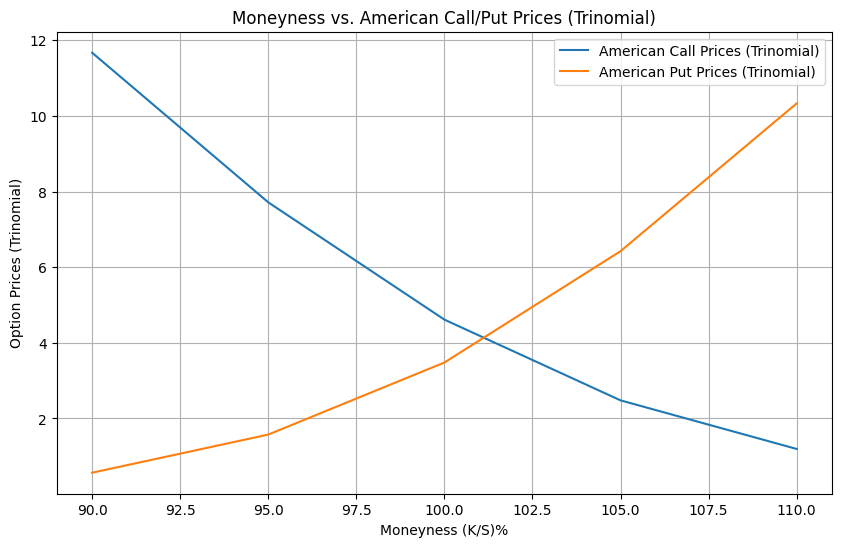

In [28]:
plt.figure(figsize=(10, 6))  # Adjust figure size for better visibility
plt.plot(moneyness, american_call_prices_tr, label="American Call Prices (Trinomial)")
plt.plot(moneyness, american_put_prices_tr, label="American Put Prices (Trinomial)")
plt.xlabel("Moneyness (K/S)%")
plt.ylabel("Option Prices (Trinomial)")
plt.title("Moneyness vs. American Call/Put Prices (Trinomial)")
plt.grid(True)
plt.legend()  # Add a legend to distinguish the lines
plt.show()


# Step 3

In [29]:
# S0=180, r =2%, sigma=25%, T=6months, K = 182:
S_in = 180
K = 182
r = 0.02
sigma = 0.25
T = 6/12
N = 3

call_option = Option(S_in, K, T,r, sigma, N, OptionType.call)
binomial_tree = BinomialTree(call_option)
binomial_tr_call= binomial_tree.price()
print("call price: {:.2f}".format(binomial_tr_call["price"]))

call price: 13.63


In [30]:
binomial_tr_call= binomial_tree.price()
print(binomial_tr_call["delta"])

[[0.52744585 0.         0.        ]
 [0.25525646 0.75766608 0.        ]
 [0.         0.47115467 1.        ]]


## Asian Binomial Tree

In [31]:
class AsianBinomialTree(BinomialTree):
    def __init__(self, option: Option):
        super().__init__(option)
        self.num_paths = 2**self.option.steps  # Number of paths
        self.average_prices = np.zeros(
            self.num_paths
        )  # Average stock price for each path
        self.option_payoffs = np.zeros(self.num_paths)  # Option payoff for each path
        self.path_probabilities = np.zeros(self.num_paths)  # Probability of each path
        self.path_deltas = []
        self.paths = []

    def generate_paths(self, N):
        paths = []
        for i in range(2**N):
            path = []
            for j in range(N):
                path.append((i >> j) & 1)  # 0 = down, 1 = up
            paths.append(path)
        return paths

    def calculate_delta(self, stock_prices, option_values):

        deltas = []
        for i in range(len(stock_prices) - 1):
            S_up = stock_prices[i] * self.u
            S_down = stock_prices[i] * self.d
            V_up = self.payoff(S_up)
            V_down = self.payoff(S_down)
            delta = (V_up - V_down) / (S_up - S_down) if S_up != S_down else 0
            deltas.append(delta)
        return deltas

    def price(self):
        # Generate all paths
        self.paths = self.generate_paths(self.option.steps)

        for i, path in enumerate(self.paths):
            stock_prices = [S0]  # Start with S0
            for move in path:
                if move == 1:  # Up movement
                    stock_prices.append(stock_prices[-1] * self.u)
                else:  # Down movement
                    stock_prices.append(stock_prices[-1] * self.d)

            # Calculate the average stock price for this path
            self.average_prices[i] = np.mean(stock_prices)
            self.option_payoffs[i] = self.payoff(self.average_prices[i])

            # Calculate the probability of this path
            num_ups = sum(path)
            num_downs = N - num_ups
            self.path_probabilities[i] = (p**num_ups) * ((1 - p) ** num_downs)

            # Calculate deltas along the path
            deltas = self.calculate_delta(stock_prices, self.option_payoffs)
            self.path_deltas.append(deltas)

        # Step 2: Calculate the option price as the weighted average of payoffs
        option_price = np.sum(self.option_payoffs * self.path_probabilities)

        return {
            "price": option_price,
            "delta": self.path_deltas,
            "paths": paths,
            "average_prices": self.average_prices,
            "option_payoffs": self.option_payoffs,
            "path_probabilities": self.path_probabilities,
        }

    def print_paths(self):

        print("Path Details:")
        for i, path in enumerate(self.paths):
            path_str = "".join(["u" if x == 1 else "d" for x in path])
            print(f"Path {i + 1} ({path_str}):")
            print(f"  Average Stock Price: {self.average_prices[i]:.2f}")
            print(f"  Option Payoff: {self.option_payoffs[i]:.2f}")
            print(f"  Path Probability: {self.path_probabilities[i]:.3f}")
            print(
                f"  Path Deltas: {[f'{delta:.3f}' for delta in self.path_deltas[i]]}\n"
            )

        # Store results in matrices
        results_matrix = np.vstack(
            (self.average_prices, self.option_payoffs, self.path_probabilities)
        ).T
        print("\nResults Matrix (Average Price, Option Payoff, Path Probability):")
        print(results_matrix)

        # Calculate average delta at each time step
        avg_deltas = np.mean(self.path_deltas, axis=0)
        print("\nAverage Delta at each time step:")